# Project - Potato disease classification

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [32]:
batch_size = 32
image_size = 256
channels = 3
epochs = 50 

In [33]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Potato desease project/training/Plant Village",
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=batch_size
    )

Found 2152 files belonging to 3 classes.


In [34]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[0 0 0 1 1 1 0 1 1 2 1 2 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 2 0 0 0 1]


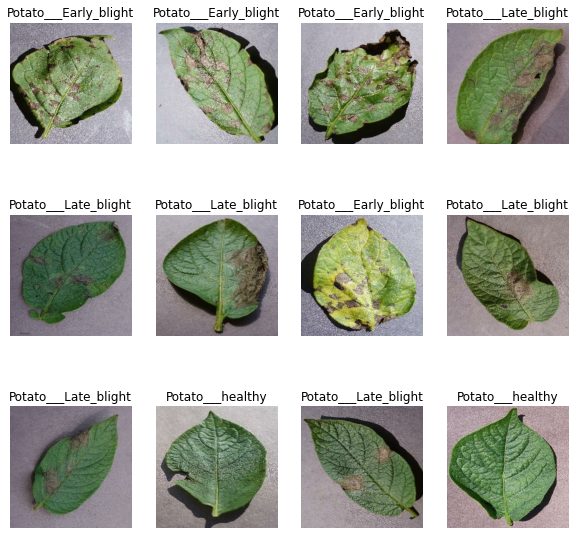

In [35]:
# explore datset
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    # Data visualization
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [36]:
#we are using 
training_data = 0.80

#test 20% -
validation_data = 0.10 #(in each epochs)
testing = 0.10

In [37]:
len(dataset)*training_data

54.400000000000006

In [38]:
train_ds = dataset.take(54)    # like o to 54 -> [:54]
len(train_ds)

54

In [39]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [40]:
val_size=0.10
len(dataset)*val_size

6.800000000000001

In [41]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [42]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [43]:
# above process in a beautiful function name - get_dataset_partitions_tf

def get_dataset_partitions_tf(ds, train_split = 0.8,val_split=0.1,test_split=0.1,shuffle=True, shuffle_size=10000):
    assert (train_split+val_split+test_split)==1
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size) 
    
    train_ds = ds.take(train_size)
    val_ds  =ds.skip(train_size).take(val_size)
    test_ds =  ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [44]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [45]:
len(train_ds), len(val_ds), len(test_ds)   

(54, 6, 8)

In [46]:
# actual pic in train_ds is :
#54*32 , 6*32, 8*32  -> (1728, 192, 256)
#1728+ 192+ 256

In [47]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [48]:
for image_batch, labels_batch in dataset.take(1):
    #print(image_batch[0].numpy())
    #print(image_batch[0].numpy().shape)
    
    print(image_batch[0].numpy()/255)
    
    # to normalize size divided by 255

[[[0.6313726  0.6431373  0.7176471 ]
  [0.65882355 0.67058825 0.74509805]
  [0.67058825 0.68235296 0.75686276]
  ...
  [0.29803923 0.32156864 0.38431373]
  [0.3647059  0.38431373 0.45882353]
  [0.42352942 0.4509804  0.52156866]]

 [[0.6        0.6117647  0.6862745 ]
  [0.61960787 0.6313726  0.7058824 ]
  [0.63529414 0.64705884 0.72156864]
  ...
  [0.53333336 0.54509807 0.6117647 ]
  [0.36078432 0.38039216 0.45490196]
  [0.27058825 0.29803923 0.36862746]]

 [[0.6        0.6117647  0.6862745 ]
  [0.6117647  0.62352943 0.69803923]
  [0.627451   0.6392157  0.7137255 ]
  ...
  [0.45882353 0.47058824 0.5372549 ]
  [0.44313726 0.46666667 0.5294118 ]
  [0.41960785 0.44313726 0.5058824 ]]

 ...

 [[0.7058824  0.7176471  0.78431374]
  [0.69803923 0.70980394 0.7764706 ]
  [0.69411767 0.7058824  0.77254903]
  ...
  [0.42745098 0.41960785 0.4745098 ]
  [0.56078434 0.5529412  0.60784316]
  [0.4627451  0.45490196 0.50980395]]

 [[0.7058824  0.7176471  0.78431374]
  [0.69803923 0.70980394 0.7764706 ]


In [49]:
# scaling
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [50]:
# data_augmentation transformation to prevent from overfitting

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),    # also we can do contrast, zoom etc
    layers.experimental.preprocessing.RandomRotation(0.2)
])

#### Buld and Train CNN

In [51]:
#           = (32, 256,256, 3)
input_shape = (batch_size,image_size,image_size, channels)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [52]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [53]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [54]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=epochs
    
)

Epoch 1/50
54/54 [==============================] - 13s 163ms/step - loss: 0.8697 - accuracy: 0.5098 - val_loss: 0.8288 - val_accuracy: 0.5833
Epoch 2/50
54/54 [==============================] - 5s 101ms/step - loss: 0.6237 - accuracy: 0.7135 - val_loss: 0.4107 - val_accuracy: 0.8021
Epoch 3/50
54/54 [==============================] - 5s 91ms/step - loss: 0.6123 - accuracy: 0.7523 - val_loss: 0.5439 - val_accuracy: 0.7812
Epoch 4/50
54/54 [==============================] - 5s 91ms/step - loss: 0.5536 - accuracy: 0.7627 - val_loss: 0.4366 - val_accuracy: 0.8177
Epoch 5/50
54/54 [==============================] - 5s 91ms/step - loss: 0.4281 - accuracy: 0.8131 - val_loss: 0.3913 - val_accuracy: 0.8177
Epoch 6/50
54/54 [==============================] - 5s 90ms/step - loss: 0.3682 - accuracy: 0.8443 - val_loss: 0.1762 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 5s 90ms/step - loss: 0.2596 - accuracy: 0.8912 - val_loss: 0.2319 - val_accuracy: 0.9219
Epoch 8/50

In [55]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 35ms/step - loss: 0.0696 - accuracy: 0.9805


In [63]:
scores

[0.0696369931101799, 0.98046875]

In [ ]:
# loss = 0.0696
# accuracy = 98.05

In [56]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [57]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [58]:
accu = history.history['accuracy']
val_accu = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

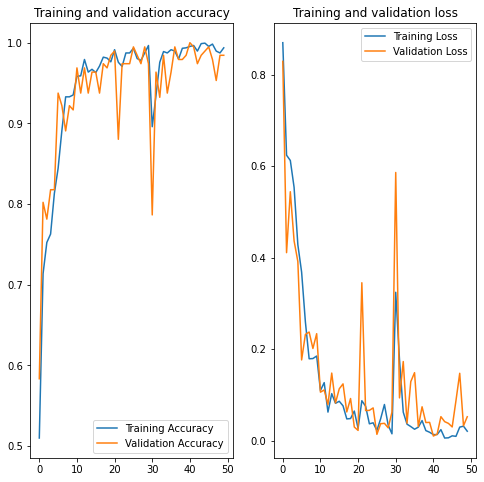

In [59]:
# plot graph on above data

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.plot(range(epochs), accu, label='Training Accuracy')
plt.plot(range(epochs), val_accu, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(122)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')
plt.show()

First image to predict
Actual Label: Potato___Late_blight
1/1 [==============================] - 0s 134ms/step
predicted label:  Potato___Late_blight


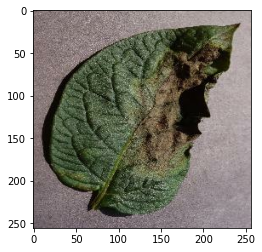

In [60]:
import numpy as np

for  image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    
    print("First image to predict")  
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label: ",class_names[np.argmax(batch_prediction[0])])

In [61]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())   # image to array
    img_array = tf.expand_dims(img_array, 0)   # to create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 15ms/step


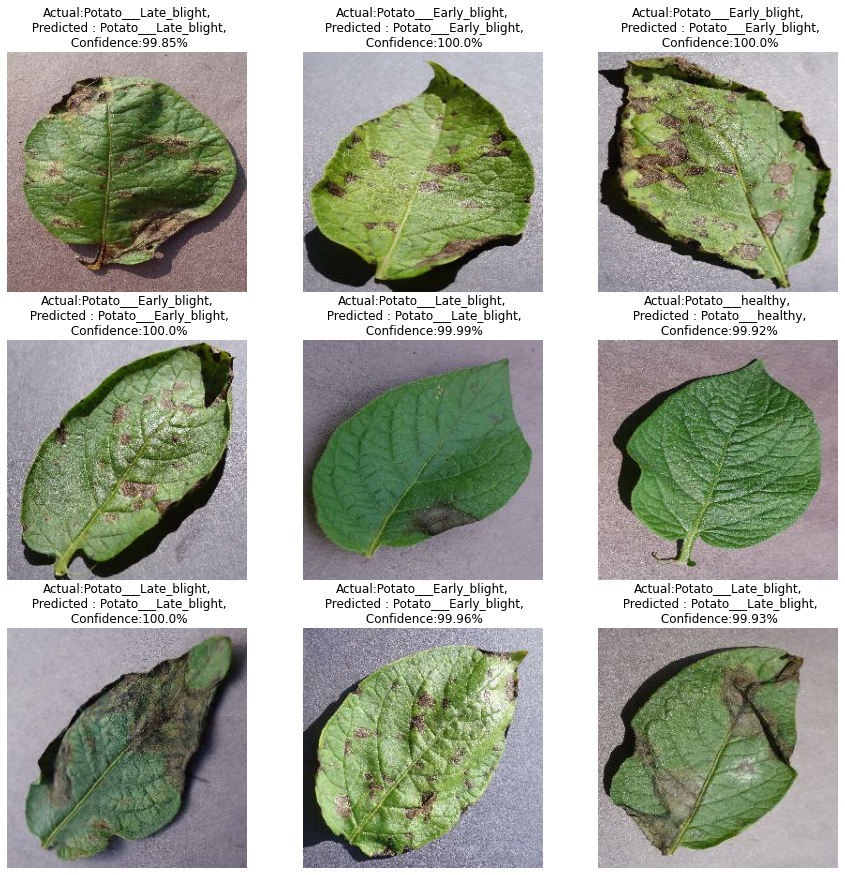

In [62]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted : {predicted_class},\n Confidence:{confidence}%")
        plt.axis('off')
    

In [ ]:
# model.save(f"../models/")

In [65]:
model_version = 1
model.save(f"/content/drive/MyDrive/Colab Notebooks/Potato desease project/models/{model_version}")

In [66]:
# Code which gives us next version of model

import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/Colab Notebooks/Potato desease project/models") + [0]])+1
model.save(f"/content/drive/MyDrive/Colab Notebooks/Potato desease project/models/{model_version}")

In [ ]:
# model.save("../potatoes.h5")